# entry network

- a network of 20 cells receiving 5 random thalamic inputs

In [1]:
# set fileName

fileName = "eg_entry-network"

# try with spinnaker and brain

In [2]:
try:
    import pyNN.spiNNaker as sim
except ModuleNotFoundError:
    import pyNN.brian2 as sim
    
from pyNN import space 
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pickle

import time
import datetime
import json
import warnings
import python_utils as pu

warnings.filterwarnings('ignore')

savePath = f'../outputs/'
dt_string = datetime.datetime.today().isoformat() # ISO8601 ! :-)
tag = dt_string 
saveName = f'{savePath}{fileName}-{tag}'
print(saveName)
PARS={}

../outputs/eg_entry-network-2024-11-28T20:41:24.307090


In [3]:
# simulation setting

dt         = 1 # ms
min_delay = 1 # ms
max_delay  = 1.0 # ms
simtime    = 1000.0 # ms

sim.setup(timestep = dt, 
          min_dealy = min_delay,
          max_delay = max_delay)

0

In [4]:
# network parameters

n_pop = 20     # Number of cells
weight = 0.05  # synaptic weight (µS)

cell_params = {
    'tau_m'      : 20.0,   # (ms)
    'tau_syn_E'  : 2.0,    # (ms)
    'tau_syn_I'  : 4.0,    # (ms)
    'e_rev_E'    : 0.0,    # (mV)
    'e_rev_I'    : -70.0,  # (mV)
    'tau_refrac' : 2.0,    # (ms)
    'v_rest'     : -60.0,  # (mV)
    'v_reset'    : -70.0,  # (mV)
    'v_thresh'   : -50.0,  # (mV)
    'cm'         : 0.5}    # (nF)

# see parameters meaning in http://neuralensemble.org/docs/PyNN/standardmodels.html

In [5]:
# making the network
pops = {}
pops['cx'] = sim.Population(n_pop, # number of cells
                       sim.IF_cond_exp, # cell model
                       cell_params, # cell parameters
                       label="cells")

# record state variables

pops['cx'].record(['spikes'])
pops['cx'].record(['v', 'gsyn_exc', 'gsyn_inh'])

selected random sources [2, 18, 4, 19, 16]


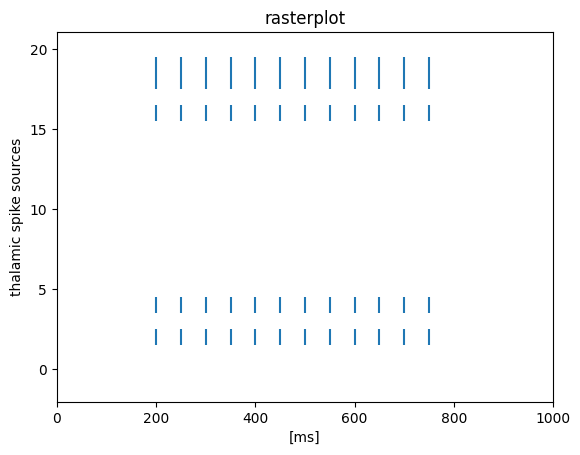

In [6]:
# designing the thalamic input

spike_times = [[]]*n_pop #list of spike lists, where one spike list is related to one spike source
random_sources_idx = [np.random.randint(0, n_pop) for i in range(5)]

for idx, sources in enumerate(random_sources_idx):
    #spike_times[sources] = [np.random.normal(loc=10, scale=0.1) for n in range(10)]
    spike_times[sources] = np.sort(np.arange(200, 800, 50).tolist())

    
pops['thalamus'] = sim.Population(n_pop, sim.SpikeSourceArray(spike_times=spike_times))
pops['thalamus'].record('spikes')

input_conns = sim.Projection(pops['thalamus'], # from 
                             pops['cx'], # to
                             connector = sim.FixedProbabilityConnector(0.5), 
                             synapse_type = sim.StaticSynapse(weight=weight, delay=min_delay),
                             receptor_type = 'excitatory')

# look the generated input
fig, ax = plt.subplots(1,1)
ax.eventplot(spike_times)
ax.set_xlabel('[ms]')
ax.set_ylabel('thalamic spike sources')
ax.set_title('rasterplot')
ax.set_xlim(0, simtime)
print('selected random sources', random_sources_idx)


In [7]:
# simulation run

tic = time.time()
sim.run(simtime)
toc = time.time() - tic

"""
a network of 20 cells receiving 5 random thalamic inputs

"""

INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.02s, trying other methods took 0.08s). [brian2.stateupdaters.base.method_choice]
WARNING    Note that the synaptic pathway 'synapses_pre' will run on the clock of the group 'spikegeneratorgroup' using a dt of 100. us. Either the Synapses object 'synapses' or the target 'neurongroup' (or both) are using a different dt. This might lead to unexpected results. In particular, all delays will be rounded to multiples of 100. us. If in doubt, try to ensure that 'spikegeneratorgroup', 'synapses', and 'neurongroup' use the same dt. [brian2.synapses.synapses.synapses_dt_mismatch]


'\na network of 20 cells receiving 5 random thalamic inputs\n\n'

In [8]:
# save the results
dosave=True
if dosave:
    outputs = {}

    outputs['cx'] = pops['cx'].get_data()
    for recording in ['v', 'gsyn_inh', 'gsyn_exc', 'spikes']:
        pops['cx'].write_data(saveName + '_' + str(recording) + '.pkl')

    outputs['thal'] = pops['thalamus'].get_data()
    for recording in ['spikes']:
        pops['thalamus'].write_data(saveName + '_' + str(recording) + '.pkl')


In [9]:
# check results

results = pu.recover_results(outputs)
results.keys()

cx
v
gsyn_exc
gsyn_inh
thal


dict_keys([('cx', 'v'), ('cx', 'gsyn_exc'), ('cx', 'gsyn_inh'), ('cx', 'spikes'), ('thal', 'spikes')])

In [10]:
# check the mean firing rate

print("CX Mean firing rate: ", pops['cx'].mean_spike_count() * 1000.0 / simtime, "Hz")

print("TH Mean firing rate: ", pops['thalamus'].mean_spike_count() * 1000.0 / simtime, "Hz")

CX Mean firing rate:  11.1 Hz
TH Mean firing rate:  3.0 Hz


(0.0, 1000.0)

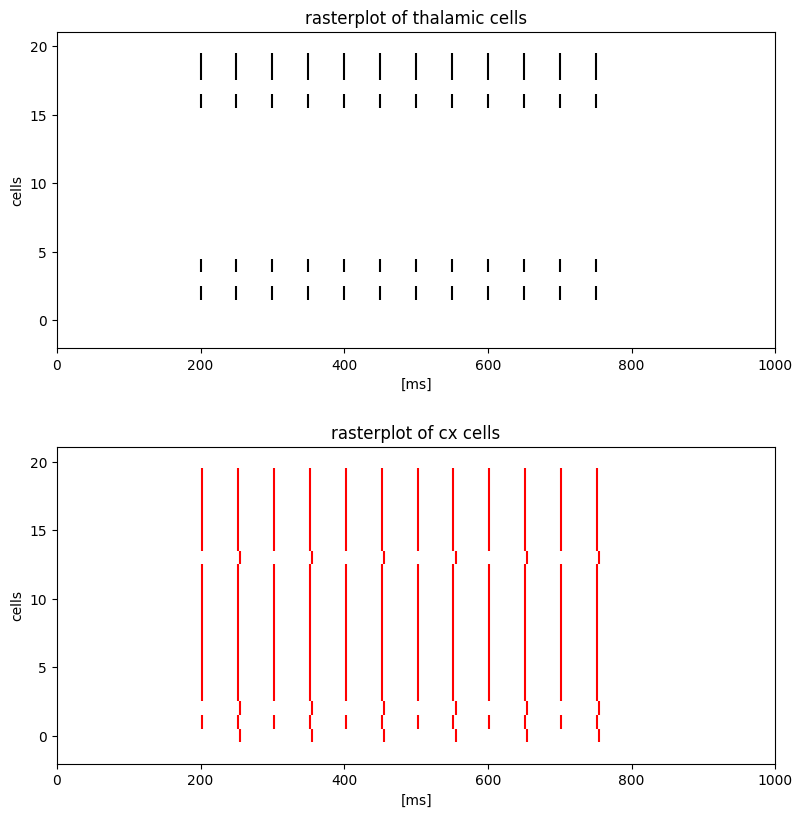

In [11]:
# check the spikes

fig, axes = plt.subplots(2,1,figsize=(9,9))
fig.tight_layout(pad=5)
axes_list = fig.axes

axes_list[0].eventplot(results['thal', 'spikes'], color='k', label='t')
axes_list[0].set_title('rasterplot of thalamic cells')
axes_list[1].set_title('rasterplot of cx cells')
axes_list[1].eventplot(results['cx', 'spikes'], color='r', label='cx')

axes_list[0].set_xlabel('[ms]')
axes_list[0].set_ylabel('cells')
axes_list[0].set_xlim(0, simtime)

axes_list[1].set_xlabel('[ms]')
axes_list[1].set_ylabel('cells')
axes_list[1].set_xlim(0, simtime)



In [12]:
random_sources_idx

[2, 18, 4, 19, 16]

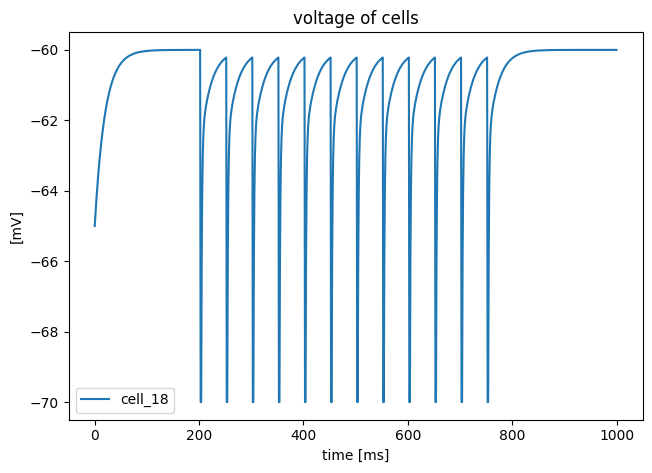

In [13]:
# check the voltage

pickedCell = random_sources_idx[1]

fig, axes = plt.subplots(1, 1, figsize=(7,5))
fig.tight_layout(pad=3)

axes_list = fig.axes
axes_list[0].plot(results['cx', 'v'].T[pickedCell], label='cell_' + str(pickedCell))

axes_list[0].set_title('voltage of cells')
axes_list[0].set_xlabel('time [ms]')
axes_list[0].set_ylabel('[mV]')
axes_list[0].legend()


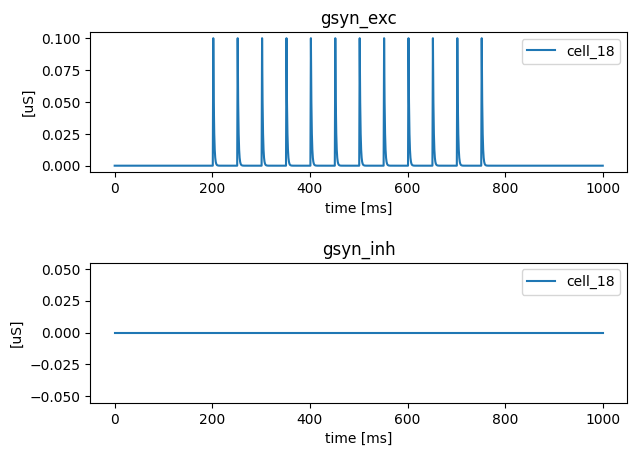

In [14]:
# check the conductance

pickedCell = random_sources_idx[1]

fig, axes = plt.subplots(2, 1, figsize=(7,5))
fig.tight_layout(pad=5)

axes_list = fig.axes

for idx, conductance in enumerate(['gsyn_exc', 'gsyn_inh']):

    fig.tight_layout(pad=3)
    axes_list = fig.axes
    axes_list[idx].plot(results['cx', conductance].T[pickedCell], label='cell_' + str(pickedCell))
    axes_list[idx].set_title(conductance)
    axes_list[idx].set_xlabel('time [ms]')
    axes_list[idx].set_ylabel('[uS]')
    axes_list[idx].legend()

## task 1: on the state variables 

- why the gsyn_inh (conductance related to cell inhibition) is equal to zero?

## task 2: on neuronal parameters

- change the tau_m (membrane time constant) parameter and have a look at the changes on the voltage trace.

- change other neuronal parameters and investigate their effect on the network behaviour

- info about parameters http://neuralensemble.org/docs/PyNN/standardmodels.html

## task 3: on neuronal model

- test another cell type looking at `sim.list_standard_models()`
